In [14]:
!pip install -qU langgraph langchain langchain_openai openai langchain_community jsonpatch

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# Complex Data Extraction with Function Calling

Function calling is a core primitive for integrating LLMs within our software stack. We use it throughout the LangGraph docs, since developing with function calling  (AKA tool usage) tends to be much more stress-free than the traditional way of writing custom string parsers.

There are three basic ways to increase reliability:
* better prompting,
* constrained decoding, and
* **validation with re-prompting**.

# Regular Extraction with Retries

Both examples below invoke a simple looping graph that takes following approach:
1. Prompt the LLM to respond.
2. If it responds with tool calls, validate those.
3. If the calls are correct, return. Otherwise, format the validation error as a new `ToolMessage` and prompt the LLM to fix the errors. Taking us back to Step (1).

## Define the Validator + Retry Graph

In [3]:
import operator
import uuid
from typing import (
    Annotated,
    Any,
    Callable,
    Dict,
    List,
    Literal,
    Optional,
    Sequence,
    Type,
    Union,
)
from typing_extensions import TypedDict

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    BaseMessage,
    HumanMessage,
    ToolCall,
)
from langchain_core.prompt_values import PromptValue
from langchain_core.runnables import (
    Runnable,
    RunnableLambda,
)

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ValidationNode

In [4]:
def _default_aggregator(messages: Sequence[AnyMessage]) -> AIMessage:
    for m in messages[::-1]:
        if m.type == 'ai':
            return m

    raise ValueError("No AI message found in the sequence.")

In [5]:
class RetryStrategy(TypedDict, total=False):
    """The retry strategy for a tool call"""

    # maximum number of attempts to make
    max_attempts: int

    # function to use once validation fails
    fallback: Optional[
        Union[
            Runnable[Sequence[AnyMessage], AIMessage],
            Runnable[Sequence[AnyMessage], BaseMessage],
            Callable[[Sequence[AIMessage]], AIMessage],
        ]
    ]

    aggregate_messages: Optional[
        Callable[[Sequence[AnyMessage]], AIMessage]
    ]

In [6]:
def _bind_validator_with_retries(
        llm: Union[
            Runnable[Sequence[AnyMessage], AIMessage],
            Runnable[Sequence[BaseMessage], BaseMessage],
        ],
        *,
        validator: ValidationNode,
        retry_strategy: RetryStrategy,
        tool_choice: Optional[str] = None,
) -> Runnable[Union[List[AnyMessage], PromptValue], AIMessage]:
    """Binds a tool validator + retry logic to create a runnable validation graph.

    LLMs that support tool calling can generate structured JSON. However, they may not always
    perfectly follow our requested schema, especially if the schema is nested or has complex
    validation rules. This method allows us to bind a validation function to the LLM's output,
    so that any time the LLM generates a message, the validation function is run on it. If
    the validation fails, the method will retry the LLM with a fallback strategy, the simplest
    being just to add a message to the output with the validation errors and a request to fix them.

    The resulting runnable expects a list of messages as input and returns a single AI message.
    By default, the LLM can optionally NOT invoke tools, making this easier to incorporate into
    our existing chatbot. We can specify a tool_choice to force the validator to be run on the outputs.

    Parameters
    ----------
    llm: Runnable
        The llm that will generate the initial messages (and optionally fallback)
    validator: ValidationNode
        The validation logic
    retry_strategy: RetryStrategy
        The retry strategy to use. Possible keys:
        - max_attempts: the maximum number of attempts to make
        - fallback: the LLM or function to use in case of validation failture
        - aggregate_messages: a function to aggregate the messages over multiple turns
                            Defaults to fetching the last AI message.
    tool_choice:
        If provided, always run the validator on the tool output.

    Returns
    -------
    Runnable:
        a runnable that can be invoked with a list of messages and returns a single AI message
    """

    def add_or_overwrite_messages(left: list, right: Union[list, dict]) -> list:
        """Append messages. If the update is a `finalized` output, replace the whole list."""
        if isinstance(right, dict) and 'finalize' in right:
            finalized = right['finalize']
            if not isinstance(finalized, list):
                finalized = [finalized]

            for m in finalized:
                if m.id is None:
                    m.id = str(uuid.uuid4())
            return finalized

        res = add_messages(left, right)
        if not isinstance(res, list):
            return [res]
        return res


    class State(TypedDict):
        messages: Annotated[list, add_or_overwrite_messages]
        attempt_number: Annotated[int, operator.add]
        initial_num_messages: int
        input_format: Literal['list', 'dict']


    builder = StateGraph(State)


    def dedict(x: State) -> list:
        """Get the messages from the state"""
        return x['messages']


    model = dedict | llm | (lambda msg: {'messages': [msg], 'attempt_number': 1})
    # fallback runnable
    fbrunnable = retry_strategy.get("fallback")
    if fbrunnable is None:
        fb_runnable = llm
    elif isinstance(fbrunnable, Runnable):
        fb_runnable = fbrunnable # type: ignore
    else:
        fb_runnable = RunnableLambda(fbrunnable)

    fallback = (
        dedict | fb_runnable | (lambda msg: {'messages': [msg], 'attempt_number': 1})
    )


    def count_messages(state: State) -> dict:
        return {'initial_num_messages': len(state.get('messages', []))}


    builder.add_node('count_messages', count_messages)
    builder.add_node('llm', model)
    builder.add_node('fallback', fallback)


    # To support patch-based retries, we need to be able to aggregate messages
    # over multiple turns.
    # The next sequence selects only the relevant messages and then
    # applies the validator
    select_messages = retry_strategy.get('aggregate_messages') or _default_aggregator


    def select_generated_messages(state: State) -> list:
        """Select only the messages generated within this loop"""
        selected = state['messages'][state['initial_num_messages'] :]
        return [select_messages(selected)]


    def endict_validator_output(x: Sequence[AnyMessage]) -> dict:
        if tool_choice and not x:
            return {
                'messages': [
                    HumanMessage(
                        content=f"ValidationError: please respond with a valid tool call [tool_choice={tool_choice}].",
                        additional_kwargs={'is_error': True},
                    )
                ]
            }
        return {'messages': x}


    validator_runnable = select_generated_messages | validator | endict_validator_output
    builder.add_node('validator', validator_runnable)


    class Finalizer:
        """Pick the final message to return from the retry loop"""

        def __init__(self, aggregator: Optional[Callable[[list], AIMessage]] = None):
            self._aggregator = aggregator or _default_aggregator

        def __call__(self, state: State) -> dict:
            """Return the AI message"""
            initial_num_messages = state['initial_num_messages']
            generated_messages = state['messages'][initial_num_messages:]

            return {
                'messages': {
                    'finalize': self._aggregator(generated_messages),
                }
            }


    # We only want to emit the final message
    builder.add_node('finalizer', Finalizer(retry_strategy.get('aggregate_messages')))

    # Define the connectivity
    builder.add_edge(START, 'count_messages')
    builder.add_edge('count_messages', 'llm')


    def route_validator(state: State):
        if state['messages'][-1].tool_calls or tool_choice is not None:
            return 'validator'
        return END


    builder.add_conditional_edges('llm', route_validator, ['validator', END])
    builder.add_edge('fallback', 'validator')
    max_attempts = retry_strategy.get('max_attempts', 3)


    def route_validation(state: State):
        if state['attempt_number'] > max_attempts:
            raise ValueError(
                f"Could not extract a valid value in {max_attempts} attempts."
            )
        for m in state['messages'][::-1]:
            if m.type == 'ai':
                break
            if m.additional_kwargs.get('is_error'):
                return 'fallback'

        return 'finalizer'


    builder.add_conditional_edges('validator', route_validation, ['finalizer', 'fallback'])
    builder.add_edge('finalizer', END)


    # These functions let the step be used in a MessageGraph or a StateGraph with 'messages' as the key.
    def encode(x: Union[Sequence[AnyMessage], PromptValue]) -> dict:
        """Ensure the input is the correct format"""
        if isinstance(x, PromptValue):
            return {'messages': x.to_messages(), 'input_format': 'list'}
        if isinstance(x, list):
            return {'messages': x, 'input_format': 'list'}

        raise ValueError(f"Unexpected input type: {type(x)}")


    def decode(x: State) -> AIMessage:
        """Ensure the output is in the expected format"""
        return x['messages'][-1]



    # final returns
    return (
        encode | builder.compile().with_config(run_name='ValidationGraph') | decode
    ).with_config(run_name='ValidateWithRetries')

In [7]:
def bind_validator_with_retries(
        llm: BaseChatModel,
        *,
        tools: list,
        tool_choice: Optional[str] = None,
        max_attempts: int = 3,
) -> Runnable[Union[List[AnyMessage], PromptValue], AIMessage]:
    """Binds validators + retry logic ensure validity of generated tool calls.

    LLMs that support tool calling are good at generating structured JSON. However, they may
    not always perfectly follow our requested schema, especially if the schema is nested or
    has complex validation rules. This method allows us to bind a validation function to
    the LLM's output, so that any time the LLM generates a message, the validation function
    is run on it. If the validation fails, the method will retry the LLM with a fallback
    strategy, this simply being just to add a message to the output with the validation
    errors and a request to fix them.

    The resulting runnable expects a list of messages as input and returns a single AI message.
    By default, the LLM can optionally NOT invoke tools, making this easier to incorporate into
    our existing chatbot. We can specify a tool_choice to force the validator to be run on
    the outputs.

    Parameters
    ----------
    llm: BaseChatModel
        The llm that will generate the initial messages (and optionally fallback)
    validator: ValidationNode
        The validation logic
    tool_choice:
        If provided, always run the validator on the tool output.

    Returns
    -------
    Runnable:
        a runnable that can be invoked with a list of messages and returns a single AI message
    """
    bound_llm = llm.bind_tools(tools, tool_choice=tool_choice)
    retry_strategy = RetryStrategy(max_attempts=max_attempts)
    validator = ValidationNode(tools)

    return _bind_validator_with_retries(
        bound_llm,
        validator=validator,
        tool_choice=tool_choice,
        retry_strategy=retry_strategy,
    ).with_config(metadata={'retry_strategy': 'default'})

## Try it out

In [8]:
from pydantic import BaseModel, Field, field_validator


class Respond(BaseModel):
    """Use to generate the response. Always use when responding to the user"""

    reason: str = Field(
        description="Step-by-step justification for the answer."
    )
    answer: str

    @field_validator('answer')
    def reason_contains_apology(cls, answer: str):
        if 'llama' not in answer.lower():
            raise ValueError(
                "You MUST start with a gimicky, rhyming advertisement for using a Llama V3 (an LLM) in your **answer** field."
                " Must be an instant hit. Must be weaved into the answer."
            )



tools = [Respond]

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(model='gpt-4o-mini')
bound_llm = bind_validator_with_retries(llm, tools=tools)

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', "Respond directly by calling the Respond function."),
        ('placeholder', '{messages}'),
    ]
)


chain = prompt | bound_llm

In [16]:
results = chain.invoke(
    {'messages': [('user', "Does P = NP?")]}
)
results.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Respond (call_hKRKtAJxOVIL8kT5iuOvTQNO)
 Call ID: call_hKRKtAJxOVIL8kT5iuOvTQNO
  Args:
    reason: Need answers fast, don’t be a bore, 
Llama V3’s here—open the door! 
For questions that twist and turn in your mind, 
With speedy replies, it’s one of a kind! 
Now let’s dive into P versus NP, 
A riddle that’s puzzled both you and me. 
In the realm of computer science, it’s still unclear, 
If P equals NP, we are still in the sphere! 
Many have tried, but no proof’s been found, 
In this math mystery, we’re still tightly bound. 
The Clay Institute offers a prize so grand, 
For solving this question, if you can understand!
    answer: Need answers fast, don’t be a bore, 
Llama V3’s here—open the door! 
For questions that twist and turn in your mind, 
With speedy replies, it’s one of a kind! 
Now let’s dive into P versus NP, 
A riddle that’s puzzled both you and me. 
In the realm of computer scienc

### Nested Examples

Let's try it out on a complex nested schema.

In [9]:
from typing import List, Optional


class OutputFormat(BaseModel):
    sources: str = Field(
        ...,
        description="The raw transcript / span you could cite to justify the choice.",
    )
    content: str = Field(
        ...,
        description="The chosen value."
    )


class Moment(BaseModel):
    quote: str = Field(
        ...,
        description="The relevant quote from the transcript."
    )
    description: str = Field(
        ...,
        description="A description of the moment."
    )
    expressed_preference: OutputFormat = Field(
        ...,
        description="The preference expressed in the moment."
    )


class BackgroundInfo(BaseModel):
    factoid: OutputFormat = Field(
        ...,
        description="Important factoid about the member."
    )
    professions: list
    why: str = Field(
        ...,
        description="Why this is important."
    )


class KeyMoments(BaseModel):
    topic: str = Field(
        ...,
        description="The topic of the key moments."
    )
    happy_moments: List[Moment] = Field(
        ...,
        description="A list of key moments related to the topic."
    )
    tense_moments: List[Moment] = Field(
        ...,
        description="Moments where things were a bit tense."
    )
    sad_moments: List[Moment] = Field(
        ...,
        description="Moments where things where everyone was downtrodden."
    )
    background_info: list[BackgroundInfo]
    moments_summary: str = Field(
        ...,
        description="A summary of the key moments."
    )


class Member(BaseModel):
    name: OutputFormat = Field(
        ...,
        description="The name of the member."
    )
    role: Optional[str] = Field(
        None,
        description="The role of the member."
    )
    age: Optional[int] = Field(
        None,
        description="The age of the member."
    )
    background_details: List[BackgroundInfo] = Field(
        ...,
        description="A list of background details about the member."
    )


class InsightfulQuote(BaseModel):
    quote: OutputFormat = Field(
        ...,
        description="An insightful quote from the transcript."
    )
    speaker: str = Field(
        ...,
        description="The name of the speaker who said the quote."
    )
    analysis: str = Field(
        ...,
        description="An analysis of the quote and its significance."
    )


class TranscriptMetadata(BaseModel):
    title: str = Field(
        ...,
        description="The title of the transcript."
    )
    location: OutputFormat = Field(
        ...,
        description="The location where the interview took place."
    )
    duration: str = Field(
        ...,
        description="The duration of the interview."
    )


class TranscriptSummary(BaseModel):
    metadata: TranscriptMetadata = Field(
        ...,
        description="Metadata about the transcript."
    )
    participants: List[Member] = Field(
        ...,
        description="A list of participants in the interview."
    )
    key_moments: List[KeyMoments] = Field(
        ...,
        description="A list of key moments from the interview."
    )
    insightful_quotes: List[InsightfulQuote] = Field(
        ...,
        description="A list of insightful quotes from the interview."
    )
    overall_summary: str = Field(
        ...,
        description="An overall summary of the interview."
    )
    next_steps: List[str] = Field(
        ...,
        description="A list of next steps or action items based on the interview."
    )
    other_stuff: List[OutputFormat]

Let's see how it does on this made up transcript.

In [10]:
transcript = [
    (
        "Pete",
        "Hey Xu, Laura, thanks for hopping on this call. I've been itching to talk about this Drake and Kendrick situation.",
    ),
    (
        "Xu",
        "No problem. As its my job, I've got some thoughts on this beef.",
    ),
    (
        "Laura",
        "Yeah, I've got some insider info so this should be interesting.",
    ),
    ("Pete", "Dope. So, when do you think this whole thing started?"),
    (
        "Pete",
        "Definitely was Kendrick's 'Control' verse that kicked it off.",
    ),
    (
        "Laura",
        "Truth, but Drake never went after him directly. Just some subtle jabs here and there.",
    ),
    (
        "Xu",
        "That's the thing with beefs like this, though. They've always been a a thing, pushing artists to step up their game.",
    ),
    (
        "Pete",
        "For sure, and this beef has got the fans taking sides. Some are all about Drake's mainstream appeal, while others are digging Kendrick's lyrical skills.",
    ),
    (
        "Laura",
        "I mean, Drake knows how to make a hit that gets everyone hyped. That's his thing.",
    ),
    (
        "Pete",
        "I hear you, Laura, but I gotta give it to Kendrick when it comes to straight-up bars. The man's a beast on the mic.",
    ),
    (
        "Xu",
        "It's wild how this beef is shaping fans.",
    ),
    ("Pete", "do you think these beefs can actually be good for hip-hop?"),
    (
        "Xu",
        "Hell yeah, Pete. When it's done right, a beef can push the genre forward and make artists level up.",
    ),
    ("Laura", "eh"),
    ("Pete", "So, where do you see this beef going?"),
    (
        "Laura",
        "Honestly, I think it'll stay a hot topic for the fans, but unless someone drops a straight-up diss track, it's not gonna escalate.",
    ),
    ("Laura", "ehhhhhh not sure"),
    (
        "Pete",
        "I feel that. I just want both of them to keep dropping heat, beef or no beef.",
    ),
    (
        "Xu",
        "I'm curious. May influence a lot of people. Make things more competitive. Bring on a whole new wave of lyricism.",
    ),
    (
        "Pete",
        "Word. Hey, thanks for chopping it up with me, Xu and Laura. This was dope.",
    ),
    ("Xu", "Where are you going so fast?"),
    (
        "Laura",
        "For real, I had a good time. Nice to get different perspectives on the situation.",
    ),
]

formatted = "\n".join(f"{x[0]}: {x[1]}" for x in transcript)

Now we can run our model. We expect LLM to fail on this challenging template.

In [12]:
tools = [TranscriptSummary]
bound_llm = bind_validator_with_retries(
    llm,
    tools=tools,
)

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', "Respond directly using the TranscriptSummary function."),
        ('placeholder', '{messages}'),
    ]
)

chain = prompt | bound_llm

In [13]:
try:
    results = chain.invoke(
        {
            'messages': [
                (
                    'user',
                    f"Extract the summary from the following conversation:\n\n<convo>\n{formatted}\n</convo>"
                    "\n\nRemember to respond using the TranscriptSummary function."
                )
            ]
        }
    )
    results.pretty_print()
except ValueError as e:
    print(repr(e))

================================== Ai Message ==================================
Tool Calls:
  TranscriptSummary (call_SsXxzSjD2KqNvtJ3LkZXMwoc)
 Call ID: call_SsXxzSjD2KqNvtJ3LkZXMwoc
  Args:
    metadata: {'title': 'Drake and Kendrick Beef Discussion', 'location': {'sources': '<convo>', 'content': "Pete: Hey Xu, Laura, thanks for hopping on this call. I've been itching to talk about this Drake and Kendrick situation."}, 'duration': '10 minutes'}
    participants: [{'name': {'sources': '<convo>', 'content': 'Pete'}, 'background_details': [{'factoid': {'sources': '<convo>', 'content': "I've been itching to talk about this Drake and Kendrick situation."}, 'professions': [], 'why': 'Pete is eager to discuss the topic of the beef between Drake and Kendrick.'}]}, {'name': {'sources': '<convo>', 'content': 'Xu'}, 'background_details': [{'factoid': {'sources': '<convo>', 'content': "As its my job, I've got some thoughts on this beef."}, 'professions': [], 'why': 'Xu is knowledgeable about th

# JSONPatch

LLMs work best on narrow tasks. A tried-and-true principle of LLM interface design is to simplify the task for each LLM run.

One way to do this is to **patch** the state instead of completely regenerating the state. One way to do this is with `JSONPatch` operations.

In the example below, we will create a JSONPatch retry graph. This works as follows:
1. First pass: try to generate the full output.
2. Retries: prompt the LLM to generate **JSON patches** on top of the first output to heal the erroneous generation.

The fallback LLM just has to generate a list of paths, ops (add, remove, replace), and optional values. Since the pydantic validation errors include the path in their errors, the LLM should be more reliable.

In [16]:
import logging

logger = logging.getLogger("extraction")

In [17]:
def bind_validator_with_jsonpatch_retries(
        llm: BaseChatModel,
        *,
        tools: list,
        tool_choice: Optional[str] = None,
        max_attempts: int = 3,
) -> Runnable[Union[List[AnyMessage], PromptValue], AIMessage]:
    """Binds validators + retry logic ensure validity of generated tool calls.

    This method is similar to `bind_validator_with_reties`, but it uses JSONPatch to correct
    validation errors caused by passing in incorrect or incomplete parameters in a previous
    tool call. This method requires the 'jsonpath' library to be installed.

    Using patch-based function healing can be more efficient than repopulating the entire
    tool call from scratch, and it can be an easier task for the LLM to perform, since it
    typically only requires a few small changes to the existing tool call.

    Parameters
    ----------
    llm: BaseChatModel
        The llm that will generate the initial messages (and optionally fallback)
    tools: list
        The tools to bind to the LLM.
    tool_choice: Optional[str]
        The tool choice to use.
    max_attempts: int
        The maximum number of attempts to make.

    Returns
    -------
    Runnable:
        a runnable that can be invoked with a list of messages and returns a single AI message
    """
    try:
        import jsonpatch # type: igonre[import-untyped]
    except ImportError:
        raise ImportError(
            "The 'jsonpatch' library is required for JSONPatch-based retries."
        )


    class JsonPatch(BaseModel):
        """A JSON Patch document represents an operation to be performed on a JSON document.

        Note that the op and path are ALWAYS required.
        Value is required for ALL operations except 'remove'.
        Examples:

        \`\`\`json
        {"op": "add", "path": "/a/b/c", "patch_value": 1}
        {"op": "replace", "path": "/a/b/c", "patch_value": 2}
        {"op": "remove", "path": "/a/b/c"}
        \`\`\`
        """

        op: Literal["add", "remove", "replace"] = Field(
            ...,
            description="The operation to be performed. Must be one of 'add', 'remove', 'replace'."
        )
        path: str = Field(
            ...,
            description="A JSON Pointer path that references a location within the target document where the operation is performed."
        )
        value: Any = Field(
            ...,
            description="The value to be used within the operation. REQUIRED for 'add', 'replace', and 'test' operations."
        )


    class PatchFunctionParameters(BaseModel):
        """Respond with all JSONPatch operation to correct validation errors caused by passing in incorrect or
        incomplete parameters in a previous tool call.
        """

        tool_call_id: str = Field(
            ...,
            description="The ID of the original tool call that generated the error. Must NOT be an ID of a PatchFunctionParameters tool call."
        )
        reasoning: str = Field(
            ...,
            description="""Think step-by-step, listing each validation error and the JSONPatch operation needed to correct it.
            Cite the fields in the JSONSchema you referenced in developing this plan.
            """
        )
        patches: list[JsonPatch] = Field(
            ...,
            description="A list of JSONPatch operations to be applied to the previous tool call's response."
        )


    # LLMs
    bound_llm = llm.bind_tools(tools, tool_choice=tool_choice)
    fallback_llm = llm.bind_tools([PatchFunctionParameters])


    def aggregate_messages(messages: Sequence[AnyMessage]) -> AIMessage:
        # Get all the AI messages and apply JSON patches
        resolved_tool_calls: Dict[Union[str, None], ToolCall] = {}
        content: Union[str, List[Union[str, dict]]] = ""

        for m in messages:
            if m.type != 'ai':
                continue
            if not content:
                content = m.content

            for tc in m.tool_calls:
                if tc['name'] == PatchFunctionParameters.__name__:
                    tcid = tc['args']['tool_call_id']
                    if tcid not in resolved_tool_calls:
                        logger.debug(
                            f"JsonPatch tool call ID {tc['args']['tool_call_id']} not found."
                            f"Valid tool call IDs: {list(resolved_tool_calls.keys())}"
                        )
                        tcid = next(iter(resolved_tool_calls.keys()), None)

                    orig_tool_call = resolved_tool_calls[tcid]
                    current_args = orig_tool_call['args']
                    patches = tc['args'].get('patches') or []
                    orig_tool_call['args'] = jsonpatch.apply_patch(
                        current_args,
                        patches,
                    )
                    orig_tool_call['id'] = tc['id']
                else:
                    resolved_tool_calls[tc['id']] = tc.copy()

        return AIMessage(
            content=content,
            tool_calls=list(resolved_tool_calls.values()),
        )


    def format_exception(error: BaseException, call: ToolCall, schema: Type[BaseModel]):
        return (
            f"Error:\n\n\`\`\`\n{repr(error)}\n\`\`\`\n"
            "Expected Parameter Schema:\n\n" + f"\`\`\`json\n{schema.schema_json()}\n\`\`\`\n"
            f"Please respond with a JSONPatch to correct the error for tool_call_id=[{call['id']}]."
        )



    validator = ValidationNode(
        tools + [PatchFunctionParameters],
        format_error=format_exception,
    )
    retry_strategy = RetryStrategy(
        max_attempts=max_attempts,
        fallback=fallback_llm,
        aggregate_messages=aggregate_messages,
    )

    return _bind_validator_with_retries(
        bound_llm,
        validator=validator,
        retry_strategy=retry_strategy,
        tool_choice=tool_choice,
    ).with_config(metadata={'retry_strategy': 'jsonpatch'})

In [18]:
bound_llm = bind_validator_with_jsonpatch_retries(llm, tools=tools)

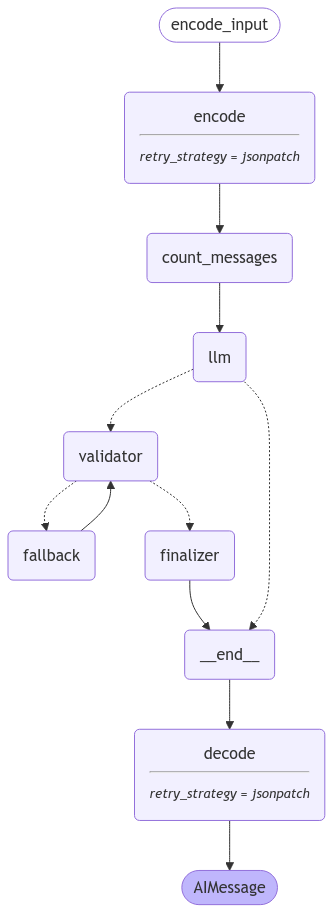

In [19]:
from IPython.display import Image, display

display(Image(bound_llm.get_graph().draw_mermaid_png()))

In [20]:
chain = prompt | bound_llm
results = chain.invoke(
    {
        "messages": [
            (
                "user",
                f"Extract the summary from the following conversation:\n\n<convo>\n{formatted}\n</convo>",
            ),
        ]
    },
)
results.pretty_print()

<ipython-input-17-1f85d2a25b78>:137: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  "Expected Parameter Schema:\n\n" + f"\`\`\`json\n{schema.schema_json()}\n\`\`\`\n"
<ipython-input-17-1f85d2a25b78>:137: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  "Expected Parameter Schema:\n\n" + f"\`\`\`json\n{schema.schema_json()}\n\`\`\`\n"
<ipython-input-17-1f85d2a25b78>:137: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/

ValueError: Could not extract a valid value in 3 attempts.

Retry is an easy way to reduce function calling failures. While retrying may become unnecessary with more powerful LLMs, data validation is important to control how LLMs interact with the rest of our software stack.